# Makemore - Initialization and BatchNorm

This notebook is a summary and re-implementation of Andrej Karpathy's [Building makemore Part 3: Activations & Gradients, BatchNorm](https://youtu.be/P6sfmUTpUmc?si=epSJSH4sBF08J_SO) as part of the Neural Networks: Zero to Hero series.

There are 5 main takeaways from this lecture:
1. Why bad initialization can harm neural network training
2. How to find correct initialization values (Kaiming He Init)
3. Introduction to BatchNorm
4. Diagnostic tools to determine health of NN
5. Converting our code into a PyTorch-like API

## Setup code

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set up dataset
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# hyperparameters
block_size = 3
n_embed = 10
n_hidden = 100
max_steps = 200000
batch_size = 32

In [6]:
# compile dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
# 80, 10, 10 split
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

train_X, train_Y = build_dataset(words[:n1])
valid_X, valid_Y = build_dataset(words[n1:n2])
test_X, test_Y = build_dataset(words[n2:])

## Problems with the previous training

### 1. Softmax being confidently wrong

If the output layer just before softmax provides large values, softmax will be confidently wrong, leading to a high inital loss. Let's see this by breaking out of the training loop after a single iteration.

In [7]:
# set up parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, W2, b2]

print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

5997


In [8]:
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    hpreact = emb.view(-1, n_embed * block_size) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    break

      0/ 200000: 18.8487


We see that the initial loss is ~17. Remember that the loss is the negative log of the probability of the correct token. Because the network is not yet trained, there is no reason for the network to believe that some character should be any more likely than any other character. So the expected loss should be

In [9]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

So we see that our initial loss is much larger than the expected loss. This occurs because the magnitude of our initial weights is large, so softmax gives confidently incorrect predictions. The problem with this is that training cycles are wasted on simply bringing down the magnitude of the weights, and if we plot the loss over time, we would get a hockey stick-like graph due to easy gains in the beginning, which squash the (more relevant) later parts of training. We can easily fix this by reducing the weights and biases in the output layer by multiplying the weights by a small constant (e.g. 0.01) and setting the biases to 0.

We can re-initialize with smaller output layer parameters and verify the initial loss being roughly equal to the expected loss.

In [10]:
# set up parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, W2, b2]

print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

5997


In [11]:
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    hpreact = emb.view(-1, n_embed * block_size) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    break

      0/ 200000: 3.2993


### 2. Saturated Gradients

The saturated gradient problem is when the pre-activations that feed into an activation layer such as `tanh` or `sigmoid` take on extreme values (very positive or very negative) and have very small gradients, which causes very small updates.

For example, if the activation value `t` is close to -1 or 1, you are on the flat region of the `tanh` graph, where the gradient is almost zero. This would cut off the gradient flowing backward here and cause the neuron to not update (if this happened to the neuron for all examples, the neuron would never update, which is known as a "dead neuron"). Another way to see this is through the backprop update rule for `tanh`: `self.grad += (1-t**2) * out.grad` where `self.grad` would be 0 regardless of the gradient of its parents.

Let's see this happen in our previous implementation:

In [12]:
# set up parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, W2, b2]

print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

5997


In [13]:
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    hpreact = emb.view(-1, n_embed * block_size) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    break

      0/ 200000: 3.3118


Let's plot the activations values after the first layer (`h`) and see how many of them took on extreme values:

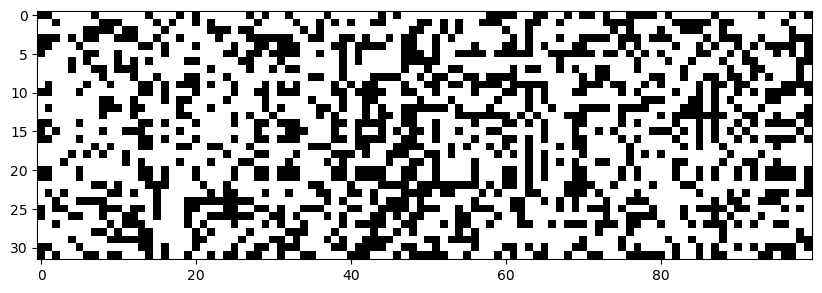

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

The white cells represent examples for which the activation was saturated. We can see that more than half of the cells are saturated, which would hinder training. (We are working with a very small network which is easier to train / more tolerant to bad initialization, but for larger networks, saturated gradients will likely halt training completely)

So how do we solve this problem? We want to lower the magnitude of the pre-activation values. Similar to above, we can multiply the weights and biases by some small value to achieve this. The `Kaiming He initialization` method is a popular method that provides a systematic way to do this that provides good activation values throughout the network. We multiply the weights with $\frac{gain}{\sqrt{input\_dim}}$ where $gain$ is a constant depending on the type of activation function.

The intuition behind the gain multiplier is to fight the contractive nature of activation functions. Assume you have multiple blocks of a linear layer followed by an activation function. Imagine the first pass through the network in which all weights were initialized without a gain. The output coming out of each block will be slightly squashed and will converge to 0 as we go deeper into the network. To fight the effect of the contraction, we need to boost the weights by a gain to renormalize everything back to unit standard deviation.

We are intentionally skipping over a lot of details here, because the paper is more mathematically involved, and modern innovations such as BatchNorm, RMSProp, and Adam made neural network training more robust to bad initialization.

Another solutinon is to use a different activation function such as `Leaky ReLU`, which does not have a flat region and is less susceptible to dying gradients.

In [15]:
# set up parameters
TANH_GAIN = 5/3
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * TANH_GAIN/((n_embed*block_size)**0.5) # Kaiming He Init
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

parameters = [C, W1, W2, b2]

print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

5997


In [16]:
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    hpreact = emb.view(-1, n_embed * block_size) @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    
    break

      0/ 200000: 3.3027


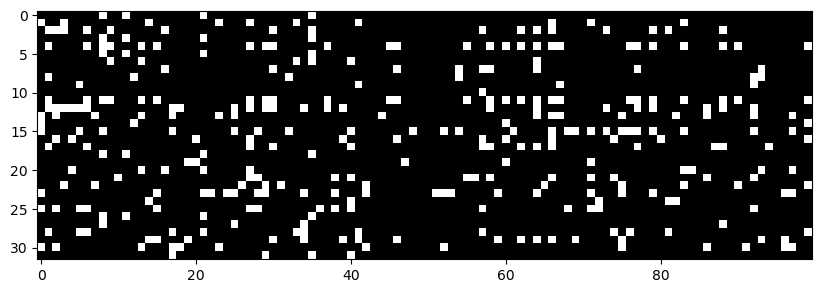

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

We see that we get a lot less activated neurons with the Kaiming He initialization.

## BatchNorm
BatchNorm is a technique due to a 2015 paper by Ioffe and Szegedy from Google Research that made it possible to train very deep models reliably.

The idea is that having roughty unit Gaussian pre-activations is good because many of them land in the non-flat region of the activation function. So we just take those pre-activations and normalize them (along each dimension of the batch) before passing them through the activation function. However, if we simply normalize them to be unit Gaussian, then most examples will fall in the range `[-1, 1]` where the activation function is mostly linear. This makes us lose the non-linearity in the network which is what allows the neural net to learn arbitrary functions. Therefore, we re-scale and re-shift the normalized values before passing them into the activation function. Because we do not know how much to re-scale and re-shift, we set them as trained parameters.

The pseudocode is as follows:

`for` each dimension of the input `do`
1. Compute mean over batch
2. Compute std over batch
3. Normalize each value by subtracting mean and dividing by std
4. Scale and shift by learned parameters $\gamma$ and $\beta$

Batch normalization allows us to control statistics of activations in the neural net. BN layers are commonly placed after linear layers or a convolutional layers.

Note that a BN layer requires the batch mean and batch variance to first normalize the inputs to unit Gaussian. For a training batch, we can simply compute the values over, but during test time, we may not be working with batches, and we need the values over the entire dataset. We do not like to have an extra step to compute the mean and variance over the dataset at the end, so we estimate them using an exponential moving average during training (this is what PyTorch does). Note that the EMA estimation is not part of backpropagation but just another computation on the side.

Also, when we are using a BN layer, the bias in the preceding layer is canceled out, so we can remove it to reduce unnecessary computation.

One strange thing that is happening with batch normalization is that examples in a batch are now coupled in the overall activation. Previously, we were simply batching examples for efficiency but each example was processed independently of others. This leads to many bugs, but BN works so well empirically that it is keep being used. One reason for the good performance is that BN works as a regularizer that adds noise, and makes it harder for the neural network to overfit to the data.

In [18]:
# set up parameters
TANH_GAIN = 5/3
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * TANH_GAIN/((n_embed*block_size)**0.5) # Kaiming He Init
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0

# BN params
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

6197


In [ ]:
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    hpreact = emb.view(-1, n_embed * block_size) @ W1# + b1
    # Batchnorm Layer
    # -------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # we are skipping addition of epsilon in the denominator
    
    # approximate mean/std of dataset during train time
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running + 0.001 * bnstdi
    # -------------------------------------------------------------------
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/ 200000: 3.2928
  10000/ 200000: 1.9752
  20000/ 200000: 2.1940
  30000/ 200000: 2.1310
  40000/ 200000: 2.4957
  50000/ 200000: 1.8258
  60000/ 200000: 2.0837
  70000/ 200000: 1.9849
  80000/ 200000: 2.5758
  90000/ 200000: 1.7949


## Introduction to PyTorch API
The PyTorch API provided by `torch.nn` gives access to classes that can be used as layers in a neural network. 

PyTorch's `nn.Linear` module takes in `fan_in` and `fan_out` (number of input and output dimensions) and initializes weights by sampling from a uniform distribution over `(-sqrt(k), sqrt(k))` where $k=\frac{1}{fan\_in}$ (the scaling by `sqrt(k)` if roughly along the lines of the Kaiming He initialization seen above).

PyTorch's `nn.BatchNorm1d` takes keyword arguments `eps` (typically not changed), `momentum` (used for computing running mean and std -- use smaller momentum if using small batch sizes), `affine` determines whether or not to add learnable gain and bias to the batch norm layer (default is `True` and should almost always be `True`), `track_running_stats` detemines whether to compute the running mean and std.

We try to replicate the PyTorch modules in the following code:

In [ ]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # NOTE: control behavior depending on training or evaluation
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = x.running_mean
            xvar = x.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum + xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum + xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

## Diagnostic tools to understand the health of a neural network

In [ ]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size),
]

with torch.no_grad():
    # make last softmax layer less confident
    layers[-1].weight *= 0.1
    # for other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    Xb, Yb = train_X[ix], train_Y[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # LR decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # NOTE: I am not sure why we are using std here to meausre the grad:data ratio, I think it should be norm/mean
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

In [ ]:
# visualize activations from Tanh layers
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title("activation distribution (forward pass)")

We see that the first layer is quite saturated, but stabilizes in the later layers, which looks healthy. We would not want the saturation to be too high or too low.

In [ ]:
# visualize gradients from Tanh layers
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title("gradient distribution (backward pass)")

Main thing to note from this plot is that the gradients in different layers have similar values (desirable). 

In [ ]:
# visualize gradients of parameters
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only focus on 2-dimensional params -- i.e. weights, not biases
        # NOTE: I am not sure why we are using std here to meausre the grad:data ratio, I think it should be norm/mean
        print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.mean() / p.mean()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 (heuristically), indicate on plot
plt.legend(legends);
# NOTE: this is also a good way to determine learning rate

Using BN layers make the network much more robust to bad initialization. All the plots above, except the last, will still look similar if we removed the weight adjustments (multiplying gain). The update to data ratios will still be bad if we do not have good initialization values, but that can be fixed by simply tuning the learning rate.